In [51]:
#Instale os pacotes
!pip install basedosdados -q
!pip install shapely -q
!pip install geopandas -q

In [2]:
#Importe as bibliotecas
import basedosdados as bd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from shapely import wkt
import matplotlib.pyplot as plt
import geopandas as gpd
import shapely
import mapclassify


In [17]:
#Query para calcular o valor médio da construção/construído dos
#por CEP na cidade de SP.
#Observe que utilizo a geometria da cidade de SP para plotar os gráficos
#dentro da cidade, de fato.
query = '''
WITH city AS (
  SELECT ST_GeogFromText(geometria) AS geometry
  FROM `basedosdados.br_geobr_mapas.municipio`
  WHERE id_municipio = '3550308'
),
points AS (
  WITH top1000 AS (
  SELECT
    b.cep,
    b.logradouro,
    b.bairro,
    cidade,
    AVG(valor_construcao) as valor_construcao,
    ST_CENTROID_AGG(centroide) as centroide
  FROM `basedosdados.br_sp_saopaulo_geosampa_iptu.iptu` a
  INNER JOIN `basedosdados.br_bd_diretorios_brasil.cep` b
  ON a.cep = b.cep
  WHERE ano = 2023 AND id_municipio = '3550308' AND
  cidade = 'São Paulo'
  GROUP BY cep, logradouro, bairro, cidade
  ORDER BY valor_construcao DESC
  LIMIT 1000
),
under1000 AS (
  SELECT
    b.cep,
    b.logradouro,
    b.bairro,
    cidade,
    AVG(valor_construcao) as valor_construcao,
    ST_CENTROID_AGG(centroide) as centroide
  FROM `basedosdados.br_sp_saopaulo_geosampa_iptu.iptu` a
  INNER JOIN `basedosdados.br_bd_diretorios_brasil.cep` b
  ON a.cep = b.cep
  WHERE ano = 2023 AND valor_construcao > 0.0 AND id_municipio = '3550308'AND
  cidade = 'São Paulo'
  GROUP BY cep, logradouro, bairro, cidade
  ORDER BY valor_construcao ASC
  LIMIT 1000
)
SELECT * FROM top1000
UNION ALL
SELECT * FROM under1000
)
SELECT
  cep,
  logradouro,
  bairro,
  cidade,
  valor_construcao,
  centroide
FROM points, city
WHERE ST_WITHIN(points.centroide, city.geometry)
'''

df= bd.read_sql(query, billing_project_id='basedosdados-dev')

Downloading: 100%|██████████| 1974/1974 [00:00<00:00, 4918.64rows/s]


In [27]:
#Correção da geometria de pontos
from shapely.geometry import Point
df['centroide'].apply(lambda x: isinstance(x, Point)).all()

True

In [19]:
#Correção da geometria de pontos
df.loc[~df['centroide'].apply(lambda x: isinstance(x, Point))]

,cep,logradouro,bairro,cidade,valor_construcao,centroide
0,08371075,Rua Humberto Allen,Jardim Augusto,São Paulo,9270.000000,POINT(-46.4483221 -23.595079)
1,03932060,Travessa Constelação do Cisne,Cidade Centenário,São Paulo,12220.000000,POINT(-46.5023788 -23.5835071)
2,08473530,Travessa Maurício Rocha e Silva,Conjunto Habitacional Barro Branco II,São Paulo,12220.000000,POINT(-46.396223 -23.5855947)
3,05207085,Caminho Omar Bradley,Vila Caiúba,São Paulo,12220.000000,POINT(-46.7556063 -23.4001727)
4,08473554,Travessa Miguel Meirelles,Conjunto Habitacional Barro Branco II,São Paulo,12220.000000,POINT(-46.3970195 -23.5849876)
...,...,...,...,...,...,...
1969,04513901,"Rua Marcos Lopes, 132",Vila Nova Conceição,São Paulo,32100.000000,POINT(-46.6711634 -23.5963335)
1970,04006907,"Rua Afonso de Freitas, 550",Paraíso,São Paulo,32100.000000,POINT(-46.6470528 -23.5761031)
1971,01243020,Rua Pará,Consolação,São Paulo,32026.696429,POINT(-46.6595169 -23.5488552)
1972,04538110,Rua Viradouro,Itaim Bibi,São Paulo,31987.604167,POINT(-46.680753 -23.5853322)


In [20]:
#Correção para verificar se existe um valor inválido
for value in df['centroide']:
    try:
        shapely.wkt.loads(value)
    except:
        print(f"Invalid WKT: {value}")

In [21]:
#Aqui para transformar de fato em um wkt
df['centroide'] = df['centroide'].apply(lambda s: shapely.wkt.loads(s))

In [22]:
#Transformação em um Geodataframe
gdf = gpd.GeoDataFrame(df, geometry='centroide', crs='EPSG:4326')

In [15]:
gdf.head()

,cep,logradouro,bairro,cidade,valor_construcao,centroide
0,08371075,Rua Humberto Allen,Jardim Augusto,São Paulo,9270.0,POINT (-46.44832 -23.59508)
1,03932060,Travessa Constelação do Cisne,Cidade Centenário,São Paulo,12220.0,POINT (-46.50238 -23.58351)
2,08473530,Travessa Maurício Rocha e Silva,Conjunto Habitacional Barro Branco II,São Paulo,12220.0,POINT (-46.39622 -23.58559)
3,05207085,Caminho Omar Bradley,Vila Caiúba,São Paulo,12220.0,POINT (-46.75561 -23.40017)
4,08473554,Travessa Miguel Meirelles,Conjunto Habitacional Barro Branco II,São Paulo,12220.0,POINT (-46.39702 -23.58499)


In [24]:
#Importar a geometria da Cidade de SP
query = '''
SELECT * FROM `basedosdados.br_geobr_mapas.municipio`
WHERE id_municipio = '3550308'
'''
sp = bd.read_sql(query, billing_project_id='basedosdados-dev')

Downloading: 100%|██████████| 1/1 [00:00<00:00,  4.25rows/s]


In [28]:
#Correção da geometria
sp['geometria'] = sp['geometria'].apply(wkt.loads)

In [32]:
#Transformação em geodataframe
sp = gpd.GeoDataFrame(sp, geometry='geometria')

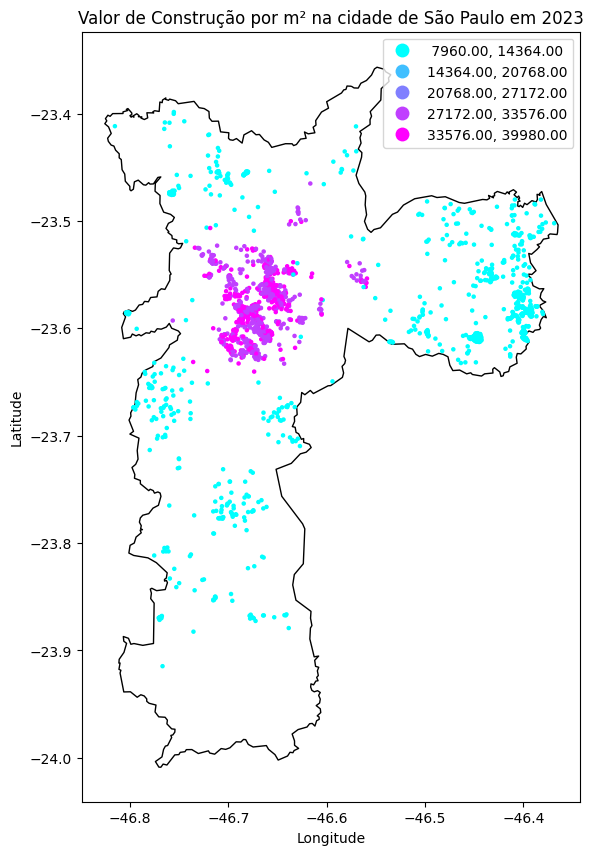

In [52]:
# Plot do mapa. Design e padronização da Base dos Dados realizado por Luiza
#e Giovane Caruso no Figma.
ax2 = sp.plot(color='white', edgecolor='black', figsize=(15,10))
ax = gdf.plot(column='valor_construcao', cmap='cool', markersize=5,
              ax = ax2, legend=True,
              scheme='EqualInterval')
ax.set_title('Valor de Construção por m² na cidade de São Paulo em 2023')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
plt.show()
#Posteriormente salvo em .svg
